In [1]:
# 일부만 할당된 GPU 메모리를 실행하는 동안 필요한만큼 늘릴 수 있도록 설정함
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [2]:
# 동일한 결과를 재현하기 위해서 random seed 고정
import numpy as np

np.random.seed(777)

In [3]:
# 모델 학습 시 불필요한 출력을 끄도록 함 (warning)
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)

# 1. 데이터 준비

In [4]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [5]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [6]:
print(train_targets) # 단위: 천 달러

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 21.1 13.6
 32.2 13.1

# 2. 데이터 전처리

In [7]:
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

# 테스트 셋도 훈련 셋에서 계산된 mean과 std를 동일하게 사용함
# 만약 각각 정규화를 수행해버리면, 학습 결과 적용이 불가능해짐
test_data -= mean
test_data /= std

# 3. 네트워크 정의

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(Dense(1)) # 회귀 모델 (출력층에 활성화 함수 없음)
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

# 4. (K-겹 교차 검증을 사용한) 모델 학습

In [9]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('>> fold ', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],
                                         train_data[(i+1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],
                                            train_targets[(i+1) * num_val_samples:]],
                                           axis=0)
    
    model = build_model()
    model.fit(partial_train_data, 
              partial_train_targets,
              epochs = num_epochs,
              batch_size = 1,
              verbose = 0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

print('finished!!')

>> fold  0
>> fold  1
>> fold  2
>> fold  3
finished!!


In [10]:
print(all_scores)
mean = np.mean(all_scores)
stddev = np.std(all_scores)

print(u'%.2f \u00B1(%.2f)'%(mean, stddev))

[2.1041749, 2.7143986, 3.0433896, 2.5717368]
2.61 ±(0.34)


In [11]:
'''
4-fold의 평균 validation MAE 그래프 그리기
'''

print(model.metrics_names)

['loss', 'mean_absolute_error']


In [12]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('>> fold ', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],
                                         train_data[(i+1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],
                                            train_targets[(i+1) * num_val_samples:]],
                                           axis=0)
    
    model = build_model()
    hist = model.fit(partial_train_data, 
                     partial_train_targets,
                     epochs = num_epochs,
                     batch_size = 1,
                     verbose = 0,
                     validation_data = (val_data, val_targets))
    
    mae_history = hist.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    
print('finished!!')

>> fold  0
>> fold  1
>> fold  2
>> fold  3
finished!!


In [13]:
print(all_mae_histories)

[[4.6104016, 3.4632838, 2.824047, 2.8458567, 2.4269226, 2.2648325, 2.3008049, 2.2784483, 2.1543944, 2.1961174, 2.2528293, 2.2098713, 2.0220335, 2.3499138, 2.2977564, 1.9395485, 1.989901, 1.906563, 2.09499, 2.2036355, 2.1482472, 2.1611097, 1.9980994, 2.1118066, 1.8897011, 1.9851369, 2.0258305, 2.088579, 1.8626087, 1.7571441, 2.1656344, 1.8498253, 2.0142746, 2.1878672, 2.0275097, 1.8577193, 2.0782764, 2.0773036, 1.7481501, 2.0537739, 2.0622647, 2.0491416, 2.2230213, 1.9057487, 1.9472346, 1.9096178, 2.2303712, 2.1304145, 1.9353513, 2.064103, 1.9068844, 2.006572, 2.150982, 1.7535794, 2.2820776, 2.1822958, 1.8861543, 1.9898361, 1.9778409, 1.926214, 2.0823545, 2.139705, 2.0955598, 2.1283324, 1.9180698, 1.9344147, 2.0730789, 1.9557921, 2.3136833, 2.1290786, 2.019083, 1.872533, 1.8913206, 2.377101, 2.1335084, 2.3428314, 2.011732, 2.4944324, 2.6371553, 2.2513797, 2.2121425, 2.0592327, 2.1914978, 1.8835539, 2.067749, 2.2140968, 2.155371, 2.1936395, 2.1229224, 2.1564121, 2.4526784, 2.1299803, 2.0

In [14]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

print(average_mae_history)

[4.917387, 3.5798504, 3.1330364, 3.025104, 2.7975285, 2.7948174, 2.811696, 2.6356037, 2.579649, 2.6010814, 2.5583563, 2.5257235, 2.498394, 2.5830112, 2.6071067, 2.4294424, 2.5086932, 2.447858, 2.552207, 2.502631, 2.4285712, 2.4185774, 2.4323764, 2.538703, 2.3454616, 2.4304862, 2.4715648, 2.3883061, 2.2928762, 2.303258, 2.4425316, 2.2546797, 2.3429704, 2.5505044, 2.4557352, 2.381892, 2.3759336, 2.364733, 2.424453, 2.3807406, 2.376905, 2.3468275, 2.441771, 2.3213792, 2.3120563, 2.3357267, 2.3960567, 2.3130977, 2.3512344, 2.356761, 2.3612537, 2.506977, 2.501554, 2.2414334, 2.5312278, 2.3727252, 2.4224296, 2.3376644, 2.352748, 2.265801, 2.285498, 2.3677485, 2.3474216, 2.4475658, 2.2761998, 2.3008637, 2.3303258, 2.3027143, 2.4622774, 2.452853, 2.3700192, 2.3561277, 2.322412, 2.4663591, 2.385713, 2.4474287, 2.3249092, 2.475336, 2.481534, 2.356793, 2.5933547, 2.3877056, 2.4460306, 2.3018663, 2.3459296, 2.3968263, 2.419766, 2.3984165, 2.3453674, 2.3744638, 2.4171722, 2.4089587, 2.2679791, 2.28

In [15]:
average_mae_history = []
for epoch in range(num_epochs):
    average_mae_per_epoch = []
    
    for mae_history in all_mae_histories: # 4개 fold 반복
        average_mae_per_epoch.append(mae_history[epoch])
    
    mean = np.mean(temp)
    average_mae_history.append(mean)

print(average_mae_history)

[4.917387, 3.5798504, 3.1330364, 3.025104, 2.7975285, 2.7948174, 2.811696, 2.6356037, 2.579649, 2.6010814, 2.5583563, 2.5257235, 2.498394, 2.5830112, 2.6071067, 2.4294424, 2.5086932, 2.447858, 2.552207, 2.502631, 2.4285712, 2.4185774, 2.4323764, 2.538703, 2.3454616, 2.4304862, 2.4715648, 2.3883061, 2.2928762, 2.303258, 2.4425316, 2.2546797, 2.3429704, 2.5505044, 2.4557352, 2.381892, 2.3759336, 2.364733, 2.424453, 2.3807406, 2.376905, 2.3468275, 2.441771, 2.3213792, 2.3120563, 2.3357267, 2.3960567, 2.3130977, 2.3512344, 2.356761, 2.3612537, 2.506977, 2.501554, 2.2414334, 2.5312278, 2.3727252, 2.4224296, 2.3376644, 2.352748, 2.265801, 2.285498, 2.3677485, 2.3474216, 2.4475658, 2.2761998, 2.3008637, 2.3303258, 2.3027143, 2.4622774, 2.452853, 2.3700192, 2.3561277, 2.322412, 2.4663591, 2.385713, 2.4474287, 2.3249092, 2.475336, 2.481534, 2.356793, 2.5933547, 2.3877056, 2.4460306, 2.3018663, 2.3459296, 2.3968263, 2.419766, 2.3984165, 2.3453674, 2.3744638, 2.4171722, 2.4089587, 2.2679791, 2.28

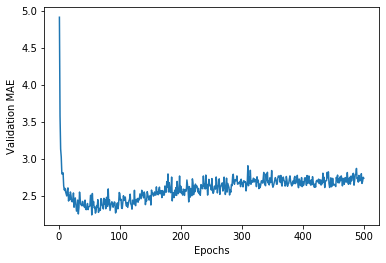

In [16]:
import matplotlib.pyplot as plt

# matplotlib이 Jupyter notebook 셀 안에서 생성되도록 함
# https://versusall.tistory.com/entry/Jupyter-Notebook-4-%EC%99%B8%EB%B6%80%EC%B0%BD%EC%97%90%EC%84%9C-%EA%B7%B8%EB%9E%98%ED%94%84-%EA%B7%B8%EB%A6%AC%EA%B8%B0-matplotlib-inline-qt-tk%C2%B6
%matplotlib inline

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

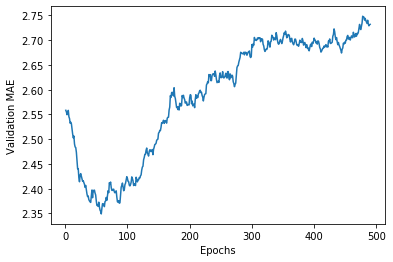

In [17]:
'''
시계열 신호에 지수 이동 평균(exponential moving averge) 필터링
'''
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            prev = smoothed_points[-1]
            smoothed_points.append(prev*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# 5. (과대적합 되기 전까지) 모델 학습

In [18]:
# 기존 model 객체를 사용하면 이어서 학습되므로, 새로운 model 객체를 생성함
model = build_model()
model.fit(train_data, 
          train_targets,
          epochs = 80,
          batch_size = 16,
          verbose = 1)

Epoch 1/80
404/404 [==============================] - 0s 654us/sample - loss: 498.5625 - mean_absolute_error: 20.3979
Epoch 2/80
404/404 [==============================] - 0s 252us/sample - loss: 338.1196 - mean_absolute_error: 16.1996
Epoch 3/80
404/404 [==============================] - 0s 240us/sample - loss: 170.0173 - mean_absolute_error: 10.6090
Epoch 4/80
404/404 [==============================] - 0s 239us/sample - loss: 71.5559 - mean_absolute_error: 6.3844
Epoch 5/80
404/404 [==============================] - 0s 238us/sample - loss: 42.0920 - mean_absolute_error: 4.7063
Epoch 6/80
404/404 [==============================] - 0s 222us/sample - loss: 30.6158 - mean_absolute_error: 3.9138
Epoch 7/80
404/404 [==============================] - 0s 227us/sample - loss: 25.4800 - mean_absolute_error: 3.5280
Epoch 8/80
404/404 [==============================] - 0s 227us/sample - loss: 22.4678 - mean_absolute_error: 3.3341
Epoch 9/80
404/404 [==============================] - 0s 217us/sam

404/404 [==============================] - 0s 207us/sample - loss: 6.4612 - mean_absolute_error: 1.7229
Epoch 72/80
404/404 [==============================] - 0s 200us/sample - loss: 6.2854 - mean_absolute_error: 1.7338
Epoch 73/80
404/404 [==============================] - 0s 200us/sample - loss: 6.1717 - mean_absolute_error: 1.6836
Epoch 74/80
404/404 [==============================] - 0s 195us/sample - loss: 6.2559 - mean_absolute_error: 1.7310
Epoch 75/80
404/404 [==============================] - 0s 197us/sample - loss: 5.9127 - mean_absolute_error: 1.6741
Epoch 76/80
404/404 [==============================] - 0s 190us/sample - loss: 6.1969 - mean_absolute_error: 1.7329
Epoch 77/80
404/404 [==============================] - 0s 195us/sample - loss: 6.1915 - mean_absolute_error: 1.6974
Epoch 78/80
404/404 [==============================] - 0s 197us/sample - loss: 6.0633 - mean_absolute_error: 1.6931
Epoch 79/80
404/404 [==============================] - 0s 195us/sample - loss: 5.820

# 6. 테스트셋으로 성능 평가하기

In [19]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print('test MSE score: %.3f', test_mse_score)
print('test MAE score: %.3f', test_mae_score)

102/102 [==============================] - 0s 978us/sample - loss: 17.6753 - mean_absolute_error: 2.7005
test MSE score: %.3f 17.675254821777344
test MAE score: %.3f 2.7004523
